In [1]:
#import the necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,classification_report
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC,SVC
import pickle

# suppress warning
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
# read csv and display 5 rows
df = pd.read_csv('data/churn_done.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Convert target label to binary
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

## Pearson Correlation
Correlation is the standardized covariance, i.e the covariance of x and y divided by the standard deviation of x and y. <br>
We can use this to check multicolinearity and also the direction and strength of the corelation.<br>

![pic](https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec)

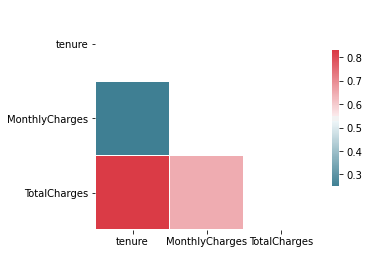

In [4]:
corr=round(df[['tenure','MonthlyCharges','TotalCharges']].corr(),2)
plt.figure(figsize=(5,5))
mask=np.triu(np.ones_like(corr,dtype=np.bool))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,square=True,annot=False,mask=mask,cmap=cmap,linewidths=0.5,cbar_kws={'shrink':0.5})
plt.show()

We can observe that TotalCharges , Monthly Charges and tenure are **highly correlated** and there's a tendency that we will maintain Total Charges. <br>We can consider dropping tenure, since TotalChargers = tenure * MonthlyChargers

# Modelling

In [5]:
# Baseline
df.Churn.value_counts(normalize=True).round(2)

0    0.73
1    0.27
Name: Churn, dtype: float64

Our baseline model is giving us an accuracy of 73%. 
It means that if we assign every row to class '0', we will be 73% correct

In [6]:
# Prepare Predictor and Target Variables
X = df.drop(['Churn'],axis=1)
y = df['Churn']

In [7]:
# Train-test-split with 20% test size and stratify set to yes
# as we want the train and test set to be balanced
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42,stratify=y)

## Logistic Regression

## Processing pipeline

In [8]:
# define the numerical and categorical columns
numerical =['MonthlyCharges','TotalCharges','tenure']
categorical= [ col for col in df.columns if col not in numerical and col!='Churn' and col!='tenure' ]

# all numeric columns will be standardized
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# all categorical columns will be One-Hot-Encoded
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# we will process numerical and categorical columns in parallel
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])

We will be using pipelines and ColumnTransformer so as to assist us with better workflow and especially for deployment.<br>
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

### RFECV

RFE is a wrapper-type feature selection algorithm. 

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

RFECV means we include Cross Validation when we fit

## **F1 scoring**

F1 scoring is used for RFECV feature selection because F1 Score keeps a balance between Precision and Recall.

AUC- ROC vs F1 Score 
In general, the ROC is used for many different levels of thresholds and thus it has many F score values. F1 score is applicable for any particular point on the ROC curve.

You may think of it as a measure of precision and recall at a particular threshold value whereas AUC is the area under the ROC curve. For F score to be high, both precision and recall should be high.

When you have a data imbalance between positive and negative samples, you should always use F1-score because of ROC averages over all possible thresholds.

![pic](https://lh4.googleusercontent.com/kGNsnAScbuhUL2JXNXmoKQhhi8N6P7yT1yrAt_KEaPet_1XiptjcutS6Xi83Ja1EbIJbeEjDYFVJI9fQwJVAtl31o4CJIQEtNvcdeB2VMiVYBxyULgaXO1JMUc-F2CcDn_Wlpd_R)

In [9]:
# fit RFECV using LogReg to obtain the best features

estimator = LogisticRegression(max_iter=1000, tol=0.1,random_state=42)
pipe_rfecv = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfecv',RFECV(estimator, step=1, cv=5,scoring='f1',n_jobs=-1))])
pipe_rfecv.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_multi',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                          

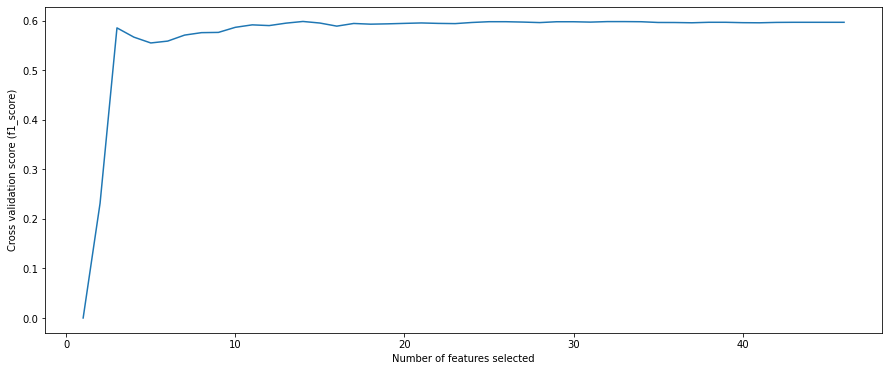

Optimal number of features : 14


In [10]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_score)")
plt.plot(range(1, len(pipe_rfecv['rfecv'].grid_scores_) + 1), pipe_rfecv['rfecv'].grid_scores_)
plt.show()
print("Optimal number of features : %d" % pipe_rfecv['rfecv'].n_features_)

In [11]:
# features that should be selected based on the boolean below
pipe_rfecv['rfecv'].support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True,  True, False,
        True, False, False, False, False,  True, False,  True,  True,
        True])

In [12]:
# obtain the categorical columns that are One Hot Encoded from pipe_rfecv
cat = pipe_rfecv['preprocessor'].transformers_[0][1]['onehot']\
                         .get_feature_names(categorical)
cat

array(['gender_Female', 'gender_Male', 'SeniorCitizen_0',
       'SeniorCitizen_1', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling

In [13]:
# obtain numerical columns
numerical

['MonthlyCharges', 'TotalCharges', 'tenure']

In [14]:
# combine both categorical and numeric horizontally
cat_numeric = np.hstack([cat, numerical])

# use mask to filter 
cat_numeric[pipe_rfecv['rfecv'].support_]

array(['MultipleLines_No', 'InternetService_DSL',
       'InternetService_Fiber optic', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_Two year', 'PaymentMethod_Electronic check',
       'MonthlyCharges', 'TotalCharges', 'tenure'], dtype=object)

In [15]:
#manually filter out the important columns as they are dummified
numerical =['MonthlyCharges','TotalCharges','tenure']
categorical = ['SeniorCitizen','Dependents','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',\
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

In [16]:
# we re-initialize the numerical and categorical columns
# previously was all columns before RFECV
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])

## k-Fold Cross Validation

**Cross-validation** is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

If we set cv = 5, it means we will iterate 4 times with 5 portions divided into 4 Training Data and 1 Test Data as per illustration below.

![pic](https://miro.medium.com/max/523/1*C5FJt_NH1BWJrFSvw_6jtw.png)

In [17]:
def eval_model(model_name,parameter):
    '''This function takes in a Pipeline and its parameters. It prints the validation auc-roc score, best parameters,
    score on training data, recall score of model, precision score of model, accuracy score of model,
    ,confusion matrix,roc-auc chart. 
    
    And important parameters in dictionary format for model comparison purposes'''
    
    # Gridsearch with CV based on the model's parameter, metric used is 'roc_auc', utilizing all the CPU cores
    search = GridSearchCV(pipe,parameter, cv=5, scoring = 'f1',verbose=1,n_jobs=-1)
    search = search.fit(X_train,y_train)
    
    # Dump model for future use or deployment 
    pickle.dump(search, open('data/{}_model.pkl'.format(model_name), 'wb'))

    #Best score ROC-AUC from GridSearchCV
    best_score = search.best_score_.round(3)
    print(f'CV F1 Score: {best_score}')
      
    #Best Parameters from GridSearchCV
    best_params = search.best_params_
    print(f'Best Params: {best_params}')
    
    #save Best model from GridSearchCV
    best_model = search.best_estimator_ 
    
    #Make predictions using best model on test data
    y_pred = search.predict(X_test)
    
    #Plot confusion matrix ( normalize and non-normalize)
    plot_confusion_matrix(search.best_estimator_, X_test, y_test,normalize='true',display_labels=['No Churn','Churn']);
    plot_confusion_matrix(search.best_estimator_, X_test, y_test,display_labels=['No Churn','Churn'])
    
    #Plot roc auc curve
    plot_roc_curve(search.best_estimator_, X_test, y_test);
    
    # Print Test metrics : Accuracy, Precision, Recall
    accuracy = accuracy_score(y_test,y_pred).round(3)
    print(f'Test Accuracy: {accuracy}')
    precision = precision_score(y_test,y_pred).round(2)
    print(f'Test Precision:  {precision}')
    recall = recall_score(y_test,y_pred).round(2)
    print(f'Test Recall: {recall}')
    f1 = f1_score(y_test,y_pred, average='micro').round(2)
    print(classification_report(y_test,y_pred,target_names=['No Churn','Churn']))
    
    model_dict = {}
    model_dict['val_f1'] = best_score
    model_dict['test_scores'] = ' '
    model_dict['f1'] = f1
    model_dict['accuracy'] = accuracy
    model_dict['precision'] = precision
    model_dict['recall'] = recall
    model_dict['best_params'] = [best_params]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    model_dict['cost_benefit'] = (80 * tp * 11 ) +\
                                 (65 * tn * 12 ) +\
                                 (65 * fp * 11 ) +\
                                 (-80 * fn * 12 ) 
    print(model_dict['cost_benefit'])
    # return the best model
    return search , model_dict 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    8.3s finished


CV F1 Score: 0.639
Best Params: {'logreg__C': 30, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Test Accuracy: 0.73
Test Precision:  0.5
Test Recall: 0.79
              precision    recall  f1-score   support

    No Churn       0.90      0.71      0.79      1033
       Churn       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

973485


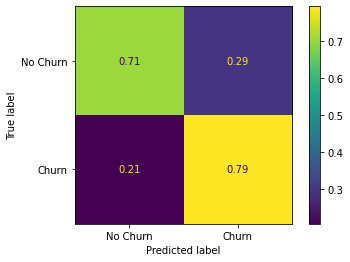

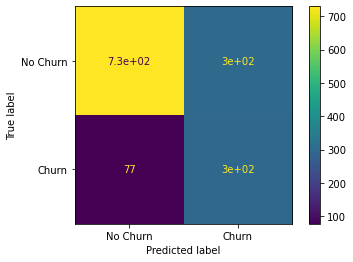

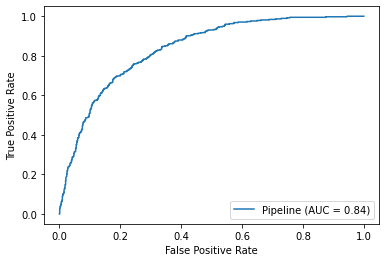

In [18]:
# we will process the columns then we will do logreg modelling
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg',LogisticRegression(max_iter=1000, tol=0.1,random_state=42))])

# parameters we will grid search
logreg_param = {
    'logreg__C': [1e-2, 1e-1, 1, 5, 10,20,30,40,50],
    'logreg__penalty' : ['l1','l2'],
    'logreg__solver' : ['lbfgs', 'liblinear','saga'],
    'logreg__class_weight' : ['balanced', None]
}

# run model evaluation
logreg,logreg_dict = eval_model('logreg',logreg_param)

## Random forest

In [20]:
categorical= [ col for col in df.columns if col not in numerical and col!='Churn' and col!='tenure' ]
# all numeric columns will be standardized
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
# all categorical columns will be One-Hot-Encoded
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# we will process numerical and categorical columns in parallel
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])
# fit RFECV using LogReg to obtain the best features
estimator = RandomForestClassifier(random_state=42)
pipe_rfecv = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfecv',RFECV(estimator, step=1, cv=5,scoring='f1_micro',n_jobs=-1))])
pipe_rfecv.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_multi',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                          

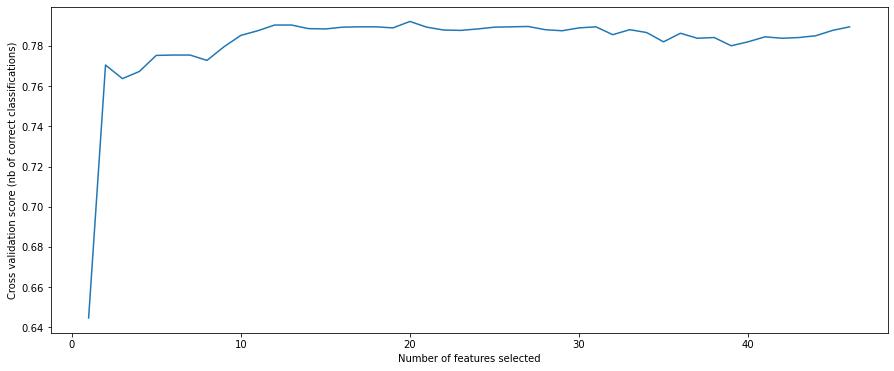

Optimal number of features : 20


In [21]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(pipe_rfecv['rfecv'].grid_scores_) + 1), pipe_rfecv['rfecv'].grid_scores_)
plt.show()
print("Optimal number of features : %d" % pipe_rfecv['rfecv'].n_features_)

In [22]:
pipe_rfecv['rfecv'].support_
cat = pipe_rfecv['preprocessor'].transformers_[0][1]['onehot']\
                         .get_feature_names(categorical)
numerical
cat_numeric = np.hstack([cat, numerical])
cat_numeric[pipe_rfecv['rfecv'].support_]

array(['gender_Female', 'gender_Male', 'SeniorCitizen_0', 'Partner_No',
       'Dependents_No', 'MultipleLines_No', 'InternetService_Fiber optic',
       'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No',
       'TechSupport_No', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check',
       'MonthlyCharges', 'TotalCharges', 'tenure'], dtype=object)

In [23]:
#manually filter out the  important columns as the columns are dummified
numerical =['MonthlyCharges','TotalCharges','tenure']
categorical = ['gender','SeniorCitizen','Partner','Dependents','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

In [24]:
# we will process numerical and categorical columns in parallel
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])

In [25]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf',RandomForestClassifier(random_state=42))])

rf_param = {
    'rf__n_estimators': [175,200,225],
    'rf__max_depth' : [7],
    'rf__min_samples_split' : [2],
    'rf__min_samples_leaf' : [2],
    'rf__oob_score' : ['True'],
    'rf__class_weight' : ['balanced', 'balanced_subsample',None]
}

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.6s finished


CV F1 Score: 0.637
Best Params: {'rf__class_weight': 'balanced', 'rf__max_depth': 7, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 175, 'rf__oob_score': 'True'}
Test Accuracy: 0.738
Test Precision:  0.5
Test Recall: 0.78
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1033
       Churn       0.50      0.78      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407

967100


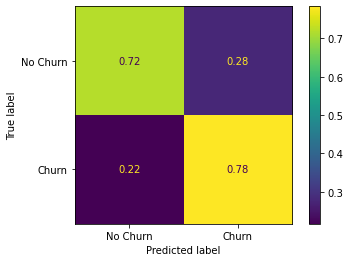

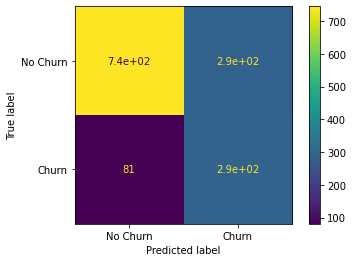

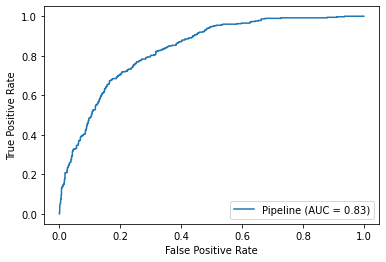

In [26]:
rf,rf_dict = eval_model('rf',rf_param)

In [27]:
pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_multi',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                          

In [28]:
feat = pipe['preprocessor'].transformers_[0][1]['onehot']\
                    .get_feature_names(categorical)
feat = np.concatenate((feat, numerical))
pd.DataFrame(data=rf.estimator[1].feature_importances_,index = feat)

,0
gender_Female,0.017519
gender_Male,0.017765
SeniorCitizen_0,0.012555
SeniorCitizen_1,0.012480
Partner_No,0.013980
Partner_Yes,0.013967
Dependents_No,0.012251
Dependents_Yes,0.012230
MultipleLines_No,0.014460
MultipleLines_No phone service,0.004851


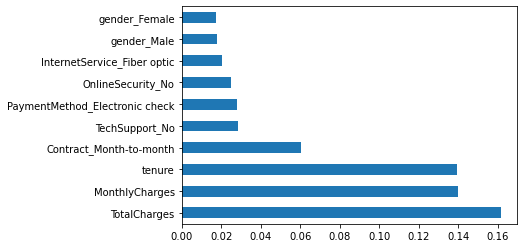

In [29]:
# display top 10 features
feat_importances = pd.Series(rf.estimator[1].feature_importances_ ,index=feat)
feat_importances.nlargest(10).plot(kind='barh');

## SVC<br>
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

* **C** is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.
* **gamma** is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set
* **kernel** parameters selects the type of hyperplane used to separate the data. Using ‘linear’ will use a linear hyperplane (a line in the case of 2D data). ‘rbf’ and ‘poly’ uses a non linear hyper-plane


In [30]:
categorical= [ col for col in df.columns if col not in numerical and col!='Churn' and col!='tenure' ]
# all numeric columns will be standardized
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
# all categorical columns will be One-Hot-Encoded
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# we will process numerical and categorical columns in parallel
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])

In [34]:
estimator = LinearSVC()
pipe_rfecv = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfecv',RFECV(estimator, step=1, cv=5,scoring='f1_micro',n_jobs=-1))])
pipe_rfecv.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_multi',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                          

In [35]:
pipe_rfecv['rfecv'].support_
cat = pipe_rfecv['preprocessor'].transformers_[0][1]['onehot']\
                         .get_feature_names(categorical)
numerical
cat_numeric = np.hstack([cat, numerical])
cat_numeric[pipe_rfecv['rfecv'].support_]

array(['PhoneService_No', 'MultipleLines_No',
       'MultipleLines_No phone service', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No',
       'StreamingTV_No internet service',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'MonthlyCharges', 'tenure'],
      dtype=object)

In [37]:
#manually filter out the  important columns as the columns are dummified
numerical =['MonthlyCharges','tenure']
categorical = ['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
               'TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']

In [54]:
svc_param = {
    'SVC__C':[1,5,6,7,8,910], #It controls the trade off between smooth decision boundary and classifying the training points correctly.
    'SVC__class_weight' : ['balanced',None]
}

In [55]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('SVC',LinearSVC(random_state=42,verbose=True))])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished


[LibLinear]CV F1 Score: 0.628
Best Params: {'SVC__C': 7, 'SVC__class_weight': 'balanced'}
Test Accuracy: 0.713
Test Precision:  0.48
Test Recall: 0.79
              precision    recall  f1-score   support

    No Churn       0.90      0.68      0.78      1033
       Churn       0.48      0.79      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

971925


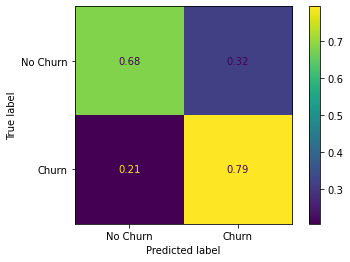

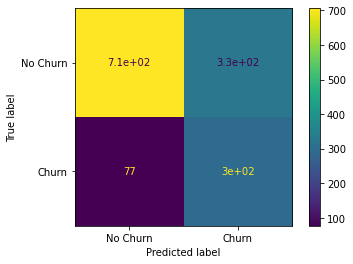

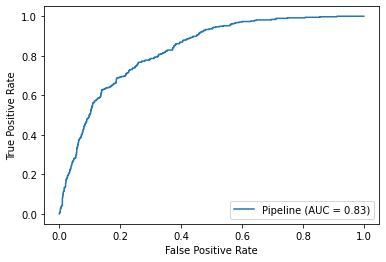

In [56]:
svc,svc_dict= eval_model('svc',svc_param)

## Comparison between the 3 models

In [57]:
pd.DataFrame([logreg_dict,rf_dict,svc_dict],\
            index=['LogReg', 'RF', 'LinearSVC']).T

,LogReg,RF,LinearSVC
val_f1,0.639,0.637,0.628
test_scores,,,
f1,0.73,0.74,0.71
accuracy,0.73,0.738,0.713
precision,0.5,0.5,0.48
recall,0.79,0.78,0.79
best_params,"[{'logreg__C': 30, 'logreg__class_weight': 'ba...","[{'rf__class_weight': 'balanced', 'rf__max_dep...","[{'SVC__C': 7, 'SVC__class_weight': 'balanced'}]"
cost_benefit,973485,967100,971925


# Cost Benefit Analysis


In [58]:
# Median Monthly Charges for Churn
df[df['Churn']==1][['MonthlyCharges']].median() #Approx $80

MonthlyCharges    79.65
dtype: float64

In [59]:
# Median Monthly Charges for  No Churn
df[df['Churn']==0][['MonthlyCharges']].median() #Approx $65

MonthlyCharges    64.45
dtype: float64

From the above, we can see that 'No Churn' customers has lesser subscription than 'Churn' customers.

We will select model based on **f1 validation score** and from here we can see that Logistic Regression has the best value of 0.639 and we verified using the Cost_Benefit analysis which is based on 1 calendar year. With LogReg, we are able to have an estimated Sales Revenue of **$973,485** 

**True Positive** =  correctly predict Churn <br> 
Total Revenue = $80 * # tp * 11<br>
Remarks : We provide free 1 month subscription to entice customer to stay but change to contract 1 year

**True Negative** = correctly predict No Churn <br> 
Total Revenue = $65 * # tn * 12 <br>
Remarks :  Business as usual 

**False Positive** = incorrectly predict Churn **Type 1 Error** <br>
Total Revenue = $65 * # fp * 11<br>
Remarks : Not as bad as FN as we only lose 1 month of revenue<br>
We provide free 1 month subscription to entice customer to stay but change to contract 1 year<br>

**False Negative** = incorrectly predict No Churn **Type 2 Error**<br>
Total Revenue = -$80 * # fn * 12 <br>
Remarks :Total revenue loss :(

**Note :**
If we go by the baseline/naive way/predict all no churn, we will totally lose at least 380 x 12 x $79 = $360,240.


In [69]:
numerical =['MonthlyCharges','TotalCharges','tenure']
categorical = ['SeniorCitizen','Dependents','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',\
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    8.3s finished


CV F1 Score: 0.639
Best Params: {'logreg__C': 30, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Test Accuracy: 0.73
Test Precision:  0.5
Test Recall: 0.79
              precision    recall  f1-score   support

    No Churn       0.90      0.71      0.79      1033
       Churn       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

973485


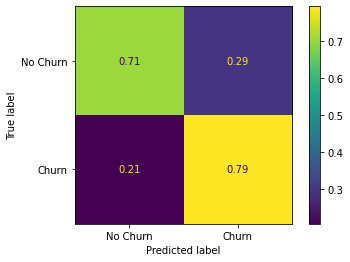

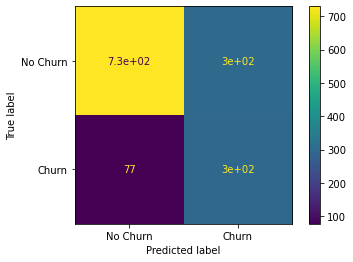

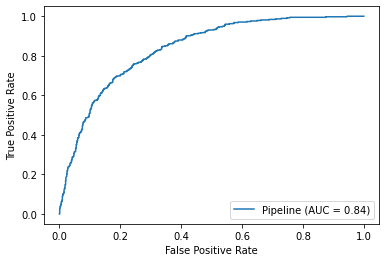

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_multi', categorical_transformer, categorical),
        ('num', numeric_transformer, numerical)])


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg',LogisticRegression(max_iter=1000, tol=0.1,random_state=42))])

# 
logreg_param = {
    'logreg__C': [1e-2, 1e-1, 1, 5, 10,20,30,40,50],
    'logreg__penalty' : ['l1','l2'],
    'logreg__solver' : ['lbfgs', 'liblinear','saga'],
    'logreg__class_weight' : ['balanced', None]
}

# run model evaluation
logreg,logreg_dict = eval_model('logreg',logreg_param)



In [106]:
cat_column = logreg.best_estimator_.named_steps["preprocessor"].transformers_[0][1]['onehot'].get_feature_names(categorical).tolist()
num_column = ['MonthlyCharges','TotalCharges','tenure','intercept']

column_name= cat_column  + num_column

## Factors that contributed to Churn (+ve)<br>
If the customer is on a **Month_to_Month** contract the tendency will be **twice as likely** since they can leave for another company easily. 

At the opposite side of the spectrum, it's tenure and contract of two years.

If the probability of success is 50%, then the odds of success are 1.<br>If the probability of success is 100%, then the odds of success are $\infty$

In [139]:
intercept = np.exp(logreg.best_estimator_.named_steps['logreg'].intercept_).round(2).tolist()
# convert logit(log-odds) to odds by np.exp() for interpretation purposes
# IF we need to convert to probability we need to odds/( 1+ odds)
coef=np.exp(logreg.best_estimator_.named_steps['logreg'].coef_).round(2).tolist()[0]
coef_intercept = coef + intercept

[0.81]

In [147]:
coef=np.exp(logreg.best_estimator_.named_steps['logreg'].coef_[0]).round(2)
odds = pd.DataFrame(coef_intercept,index=column_name,columns=["coefficient_odds"]).sort_values('coefficient_odds',ascending=False)
odds

,coefficient_odds
Contract_Month-to-month,1.99
TotalCharges,1.97
InternetService_Fiber optic,1.62
PaymentMethod_Electronic check,1.29
OnlineSecurity_No,1.22
TechSupport_No,1.17
MultipleLines_No phone service,1.16
StreamingMovies_Yes,1.16
StreamingTV_Yes,1.11
OnlineBackup_No,1.06


In [149]:
# to display in deployment
odds.to_csv('data\odds.csv')

## Conclusion

We achieve our objective of maintaining the baseline accuracy score and managed to help the company to save more than $300k and it deployed at http://dockerchurn.herokuapp.com/